In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd




In [5]:
df = pd.read_csv('data/cens.csv', sep = ";")  # Replace 'data.csv' with your actual data file

C:\Users\ferna\AppData\Local\Temp\ipykernel_24548\3258218256.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/cens.csv', sep = ";")  # Replace 'data.csv' with your actual data file


In [6]:
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290088 entries, 0 to 290087
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   any       290088 non-null  int64  
 1   geo       290088 non-null  object 
 2   municipi  290088 non-null  object 
 3   edat      290088 non-null  object 
 4   sexe      290088 non-null  object 
 5   concepte  290088 non-null  object 
 6   estat     0 non-null       float64
 7   valor     290088 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 17.7+ MB


In [10]:
df["valor"] = pd.to_numeric(df["valor"], errors="coerce")
# Eliminar las filas donde el municipio sea 'Catalunya'
df = df[df["municipi"] != "Catalunya"]


In [11]:
df_poblacio = df[df["concepte"] == "població"]


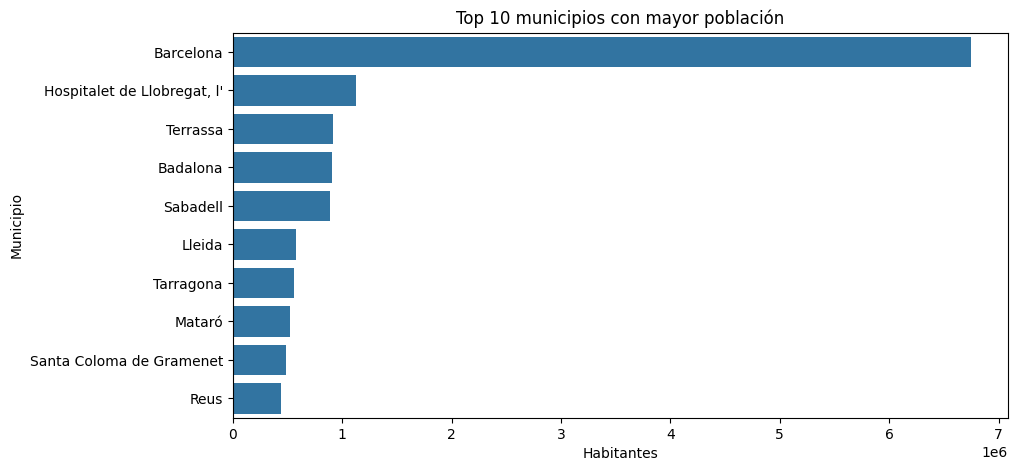

In [12]:
df_municipis = (
    df_poblacio.groupby("municipi")["valor"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
sns.barplot(x=df_municipis.values, y=df_municipis.index)
plt.title("Top 10 municipios con mayor población")
plt.xlabel("Habitantes")
plt.ylabel("Municipio")
plt.show()


In [14]:
import plotly.graph_objects as go


# Convertir "valor" a numérico
df["valor"] = pd.to_numeric(df["valor"], errors="coerce")

# Filtrar solo población total
df = df[df["concepte"] == "població"]

# -----------------------------
# 2. Preparar listado de municipios
# -----------------------------
municipis = sorted(df["municipi"].unique())

# -----------------------------
# 3. Función para obtener datos de un municipio
# -----------------------------
def obtener_datos_municipio(mun):
    temp = df[df["municipi"] == mun]

    # Población hombres y mujeres por edad
    hombres = temp[temp["sexe"] == "homes"].groupby("edat")["valor"].sum()
    mujeres = temp[temp["sexe"] == "dones"].groupby("edat")["valor"].sum()

    # Alinear edades
    edades = sorted(set(hombres.index).union(mujeres.index))

    hombres = hombres.reindex(edades, fill_value=0)
    mujeres = mujeres.reindex(edades, fill_value=0)

    # Mujeres en negativo para pirámide
    mujeres = -mujeres

    return edades, hombres, mujeres


# -----------------------------
# 4. Crear figura inicial
# -----------------------------
municipio_inicial = municipis[0]
edades, hombres, mujeres = obtener_datos_municipio(municipio_inicial)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=hombres,
    y=edades,
    orientation='h',
    name='Homes',
))

fig.add_trace(go.Bar(
    x=mujeres,
    y=edades,
    orientation='h',
    name='Dones',
))

# -----------------------------
# 5. Añadir menú interactivo
# -----------------------------
botones = []

for muni in municipis:
    e, h, m = obtener_datos_municipio(muni)
    botones.append(dict(
        label=muni,
        method="update",
        args=[
            {"x": [h, m], "y": [e, e]},  # actualizar datos
            {"title": f"Piramide poblacional - {muni}"}
        ]
    ))

fig.update_layout(
    updatemenus=[
        dict(
            buttons=botones,
            direction="down",
            showactive=True,
            x=1.05,
            y=1
        )
    ],
    barmode="overlay",
    title=f"Piramide poblacional - {municipio_inicial}",
    xaxis_title="Població (homes positius, dones negatius)",
    yaxis_title="Edat",
    template="plotly_white",
    height=700
)

fig.show()